# B3 Stocks ETL Historical Data

This Notebook aims to extract value data from the TXT file downloaded from B3 website containing the stock's historical data

B3 web site: https://www.b3.com.br/<br>
Dataset: https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/series-historicas/ <br>
File Layout: https://www.b3.com.br/data/files/33/67/B9/50/D84057102C784E47AC094EA8/SeriesHistoricas_Layout.pdf 

reference to parse b3 files: https://github.com/codigoquant/b3fileparser/


In [1]:
# importing libraries

import pandas as pd
import os
import glob
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt

load_dotenv(".env")

True

In [2]:
#%conda list -e > requirements.txt

In [3]:
stocks_target = str(os.getenv('STOCKS')).split(",")

## Concat all files in dataset dir

In [4]:
#### get path to dataset 

dataset_path = os.getenv('SRC_PATH') + '\\historical_data\\dataset\\'
# print(dataset_path)

In [5]:
#### list dataset's files

dataset_files = glob.glob(dataset_path + "\COTAHIST_*.ZIP")
# print(dataset_files)

In [6]:
### set columns info 

meta_data = {    
    "TIPREG":{'name':"TIPO_DE_REGISTRO", 'size':2 },
    "DATAPR":{'name':"DATA_DO_PREGAO", 'size':8},
    "CODBDI":{'name':"CODIGO_BDI", 'size':2},
    "CODNEG":{'name':"CODIGO_DE_NEGOCIACAO",'size':12},
    "TPMERC":{'name':"TIPO_DE_MERCADO",'size':3},
    "NOMRES":{'name':"NOME_DA_EMPRESA",'size':12},
    "ESPECI":{'name':"ESPECIFICACAO_DO_PAPEL",'size':10},
    "PRAZOT":{'name':"PRAZO_EM_DIAS_DO_MERCADO_A_TERMO",'size':3},
    "MODREF":{'name':"MOEDA_DE_REFERENCIA",'size':4},
    "PREABE":{'name':"PRECO_DE_ABERTURA",'size':13},
    "PREMAX":{'name':"PRECO_MAXIMO",'size':13},
    "PREMIN":{'name':"PRECO_MINIMO",'size':13},
    "PREMED":{'name':"PRECO_MEDIO",'size':13},
    "PREULT":{'name':"PRECO_ULTIMO_NEGOCIO",'size':13},
    "PREOFC":{'name':"PRECO_MELHOR_OFERTA_DE_COMPRA",'size':13},
    "PREOFV":{'name':"PRECO_MELHOR_OFERTA_DE_VENDAS",'size':13},
    "TOTNEG":{'name':"NUMERO_DE_NEGOCIOS",'size':5},
    "QUATOT":{'name':"QUANTIDADE_NEGOCIADA",'size':18},
    "VOLTOT":{'name':"VOLUME_TOTAL_NEGOCIADO",'size':18},
    "PREEXE":{'name':"PRECO_DE_EXERCICIO",'size':13},
    "INDOPC":{'name':"INDICADOR_DE_CORRECAO_DE_PRECOS",'size':1},
    "DATVEN":{'name':"DATA_DE_VENCIMENTO",'size':8},
    "FATCOT":{'name':"FATOR_DE_COTACAO",'size':7},
    "PTOEXE":{'name':"PRECO_DE_EXERCICIO_EM_PONTOS",'size':13},
    "CODISI":{'name':"CODIGO_ISIN",'size':12},
    "DISMES":{'name':"NUMERO_DE_DISTRIBUICAO",'size':3}
}

sizes = [ item['size'] for item in meta_data.values() ]
names = [ item['name'] for item in meta_data.values() ]

In [7]:
### function that reads the TXT file and define header

from io import BytesIO
from zipfile import ZipFile


def read_b3_file(file_name):

    if not (file_name.endswith('TXT') or file_name.endswith('ZIP')):
        print('Invalid format! Provide a .TXT or .ZIP file containing a .TXT')
        return
    
    if file_name.endswith('.ZIP'):
        with ZipFile(file_name, mode='r') as file_zip:                         
            file_name_txt = os.path.basename(file_name).replace('.ZIP', '.TXT')
            file = BytesIO(file_zip.read(file_name_txt))                      
        
    if file_name.endswith('.TXT'):
        file = file_name
   
    
    df =  pd.read_fwf(
        file,
        widths=sizes,
        header=None,
        names=names
    )

    # FILTER TARGET STOKS 
    df_target = df.loc[df['CODIGO_DE_NEGOCIACAO'].isin(stocks_target)].copy()
    df.sort_values(by=['DATA_DO_PREGAO'], ascending=True, inplace = True)
    return df_target


In [8]:
#### read the files and concat them in one dataframe with header
li = []
for f in dataset_files:
    li.append(read_b3_file(f))

df = pd.concat(li, ignore_index=True)[1:-1] # takes off first and last line
df.head(5)

,TIPO_DE_REGISTRO,DATA_DO_PREGAO,CODIGO_BDI,CODIGO_DE_NEGOCIACAO,TIPO_DE_MERCADO,NOME_DA_EMPRESA,ESPECIFICACAO_DO_PAPEL,PRAZO_EM_DIAS_DO_MERCADO_A_TERMO,MOEDA_DE_REFERENCIA,PRECO_DE_ABERTURA,...,NUMERO_DE_NEGOCIOS,QUANTIDADE_NEGOCIADA,VOLUME_TOTAL_NEGOCIADO,PRECO_DE_EXERCICIO,INDICADOR_DE_CORRECAO_DE_PRECOS,DATA_DE_VENCIMENTO,FATOR_DE_COTACAO,PRECO_DE_EXERCICIO_EM_PONTOS,CODIGO_ISIN,NUMERO_DE_DISTRIBUICAO
1,1,20190102,12.0,HGLG11,10,FII CSHG LOG,CI ER,NaN,R$,13998.0,...,1418.0,29780.0,420043860.0,0.0,0.0,99991231.0,1.0,0.0,BRHGLGCTF004,201.0
2,1,20190102,12.0,HGRU11,10,FII CSHG URB,CI ER,NaN,R$,10250.0,...,3.0,100.0,1080850.0,0.0,0.0,99991231.0,1.0,0.0,BRHGRUCTF002,108.0
3,1,20190102,12.0,KNCR11,10,FII KINEA RI,CI ER,NaN,R$,10549.0,...,576.0,15210.0,160059550.0,0.0,0.0,99991231.0,1.0,0.0,BRKNCRCTF000,174.0
4,1,20190102,12.0,KNRI11,10,FII KINEA,CI ER,NaN,R$,14622.0,...,717.0,10680.0,157294830.0,0.0,0.0,99991231.0,1.0,0.0,BRKNRICTF007,198.0
5,1,20190102,12.0,VISC11,10,FII VINCI SC,CI ER,NaN,R$,10800.0,...,1473.0,20890.0,225475510.0,0.0,0.0,99991231.0,1.0,0.0,BRVISCCTF005,115.0


## Prep data

In [9]:
MARKETS = {
    10:'VISTA',
    12:'EXERCICIO_DE_OPCOES_DE_COMPRA',
    13:'EXERCÍCIO_DE_OPCOES_DE_VENDA',
    17:'LEILAO',
    20:'FRACIONARIO',
    30:'TERMO',
    50:'FUTURO_COM_RETENCAO_DE_GANHO',
    60:'FUTURO_COM_MOVIMENTACAO_CONTINUA',
    70:'OPCOES_DE_COMPRA',
    80:'OPCOES_DE_VENDA'
}

INDOPC = {
    0:'0',
    1:'US$',
    2:"TJLP",
    8:"IGPM",
    9:"URV"
}

CODBDI = {
    0:'0',
    2:"LOTE_PADRAO",
    5:"SANCIONADAS PELOS REGULAMENTOS BMFBOVESPA",
    6:"CONCORDATARIAS",
    7:"RECUPERACAO_EXTRAJUDICIAL",
    8:"RECUPERAÇÃO_JUDICIAL",
    9:"REGIME_DE_ADMINISTRACAO_ESPECIAL_TEMPORARIA",
    10:"DIREITOS_E_RECIBOS",
    11:"INTERVENCAO",
    12:"FUNDOS_IMOBILIARIOS",
    13:'13',
    14:"CERT.INVEST/TIT.DIV.PUBLICA",
    18:"OBRIGACÕES",
    22:"BÔNUS(PRIVADOS)",
    26:"APOLICES/BÔNUS/TITULOS PUBLICOS",
    32:"EXERCICIO_DE_OPCOES_DE_COMPRA_DE_INDICES",
    33:"EXERCICIO_DE_OPCOES_DE_VENDA_DE_INDICES",
    34:'34',
    35:'35',
    36:'36',
    37:'37',
    38:"EXERCICIO_DE_OPCOES_DE_COMPRA",
    42:"EXERCICIO_DE_OPCOES_DE_VENDA",
    46:"LEILAO_DE_NAO_COTADOS",
    48:"LEILAO_DE_PRIVATIZACAO",
    49:"LEILAO_DO_FUNDO_RECUPERACAO_ECONOMICA_ESPIRITO_SANTO",
    50:"LEILAO",
    51:"LEILAO_FINOR",
    52:"LEILAO_FINAM",
    53:"LEILAO_FISET",
    54:"LEILAO_DE_ACÕES_EM_MORA",
    56:"VENDAS_POR_ALVARA_JUDICIAL",
    58:"OUTROS",
    60:"PERMUTA_POR_ACÕES",
    61:"META",
    62:"MERCADO_A_TERMO",
    66:"DEBENTURES_COM_DATA_DE_VENCIMENTO_ATE_3_ANOS",
    68:"DEBENTURES_COM_DATA_DE_VENCIMENTO_MAIOR_QUE_3_ANOS",
    70:"FUTURO_COM_RETENCAO_DE_GANHOS",
    71:"MERCADO_DE_FUTURO",
    74:"OPCOES_DE_COMPRA_DE_INDICES",
    75:"OPCOES_DE_VENDA_DE_INDICES",
    78:"OPCOES_DE_COMPRA",
    82:"OPCOES_DE_VENDA",
    83:"BOVESPAFIX",
    84:"SOMA_FIX",
    90:"TERMO_VISTA_REGISTRADO",
    96:"MERCADO_FRACIONARIO",
    99:"TOTAL_GERAL"
}

In [10]:
for col in names:
    # resolve the decimal par of prices
    if col.startswith('PRECO') or col.startswith('VOLUME'):
        df[col] = df[col] / 100

    #transform date fields
    if col == "DATA_DE_VENCIMENTO":
        df[col] = df[col].astype(int).astype(str)
        df[col] = pd.to_datetime(df[col], errors='coerce')
    if col.startswith('DATA'):
        df[col] = pd.to_datetime(df[col])
    
    # fill N/A
    if col in ["CODIGO_BDI", "PRAZO_EM_DIAS_DO_MERCADO_A_TERMO", "NUMERO_DE_DISTRIBUICAO", "FATOR_DE_COTACAO", 'INDICADOR_DE_CORRECAO_DE_PRECOS']:
        df[col] = df[col].fillna(-1).astype(int)
    
    # resolves field according to the layout of b3 files
    if col == "TIPO_DE_MERCADO":
        df[col] = df[col].apply(
            lambda x: MARKETS[x])
    
    if col == "INDICADOR_DE_CORRECAO_DE_PRECOS":
        df[col] = df[col].apply(lambda x: INDOPC[x])
    
    if col == "CODIGO_BDI":
        df[col] = df[col].apply(lambda x: CODBDI[x])

df.head(5)

,TIPO_DE_REGISTRO,DATA_DO_PREGAO,CODIGO_BDI,CODIGO_DE_NEGOCIACAO,TIPO_DE_MERCADO,NOME_DA_EMPRESA,ESPECIFICACAO_DO_PAPEL,PRAZO_EM_DIAS_DO_MERCADO_A_TERMO,MOEDA_DE_REFERENCIA,PRECO_DE_ABERTURA,...,NUMERO_DE_NEGOCIOS,QUANTIDADE_NEGOCIADA,VOLUME_TOTAL_NEGOCIADO,PRECO_DE_EXERCICIO,INDICADOR_DE_CORRECAO_DE_PRECOS,DATA_DE_VENCIMENTO,FATOR_DE_COTACAO,PRECO_DE_EXERCICIO_EM_PONTOS,CODIGO_ISIN,NUMERO_DE_DISTRIBUICAO
1,1,2019-01-02,FUNDOS_IMOBILIARIOS,HGLG11,VISTA,FII CSHG LOG,CI ER,-1,R$,139.98,...,1418.0,29780.0,4200438.6,0.0,0,NaT,1,0.0,BRHGLGCTF004,201
2,1,2019-01-02,FUNDOS_IMOBILIARIOS,HGRU11,VISTA,FII CSHG URB,CI ER,-1,R$,102.50,...,3.0,100.0,10808.5,0.0,0,NaT,1,0.0,BRHGRUCTF002,108
3,1,2019-01-02,FUNDOS_IMOBILIARIOS,KNCR11,VISTA,FII KINEA RI,CI ER,-1,R$,105.49,...,576.0,15210.0,1600595.5,0.0,0,NaT,1,0.0,BRKNCRCTF000,174
4,1,2019-01-02,FUNDOS_IMOBILIARIOS,KNRI11,VISTA,FII KINEA,CI ER,-1,R$,146.22,...,717.0,10680.0,1572948.3,0.0,0,NaT,1,0.0,BRKNRICTF007,198
5,1,2019-01-02,FUNDOS_IMOBILIARIOS,VISC11,VISTA,FII VINCI SC,CI ER,-1,R$,108.00,...,1473.0,20890.0,2254755.1,0.0,0,NaT,1,0.0,BRVISCCTF005,115


## Plot historical graphs

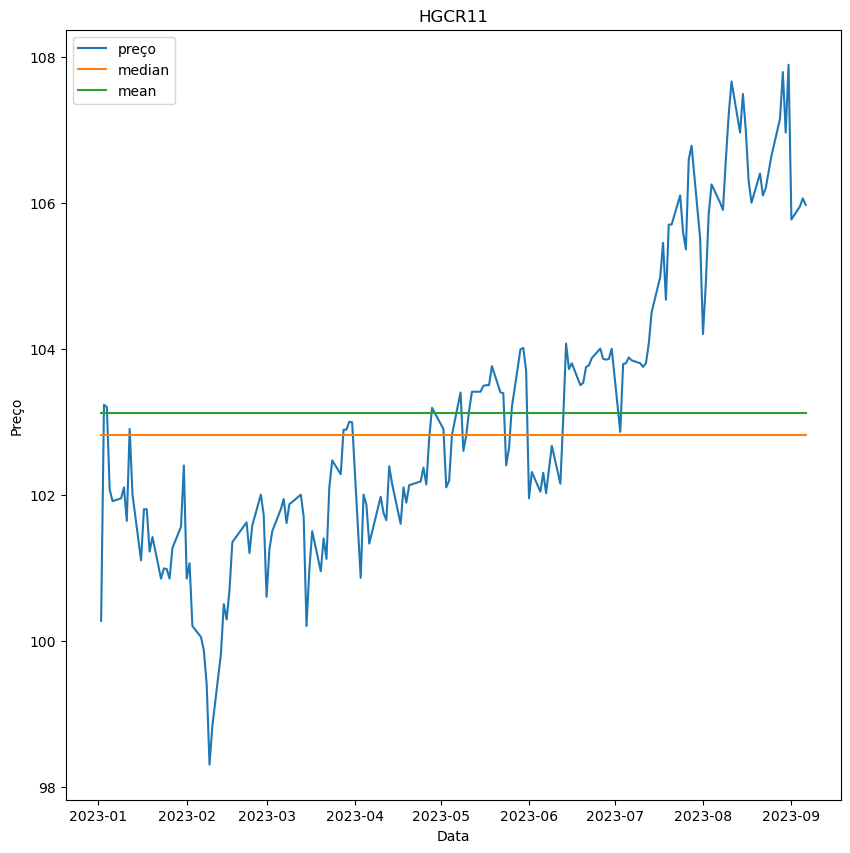

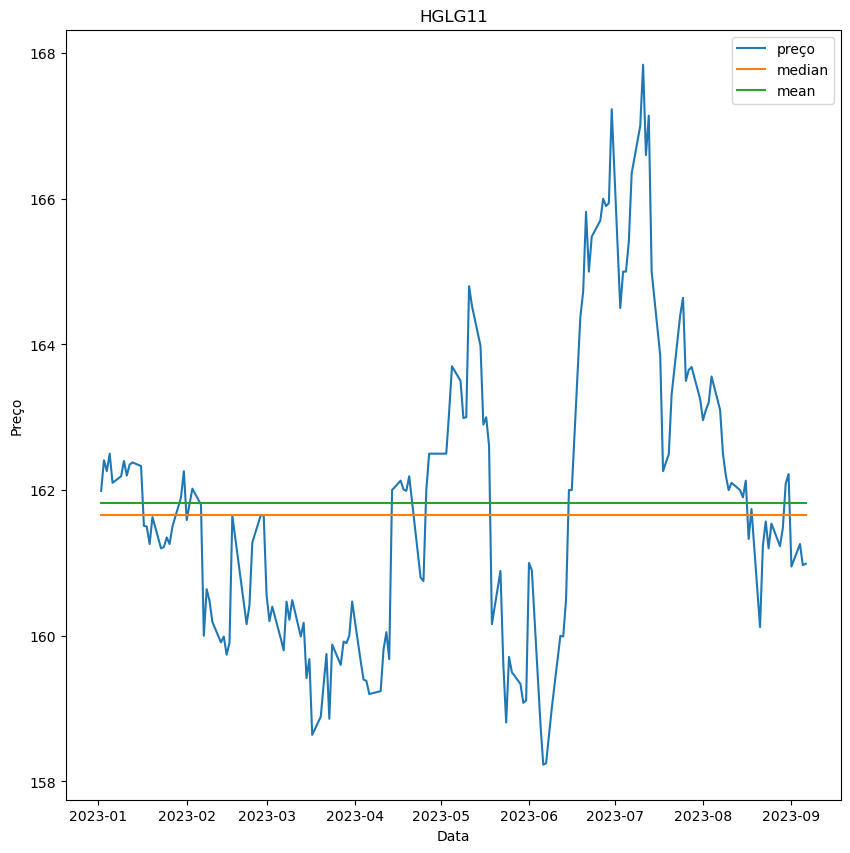

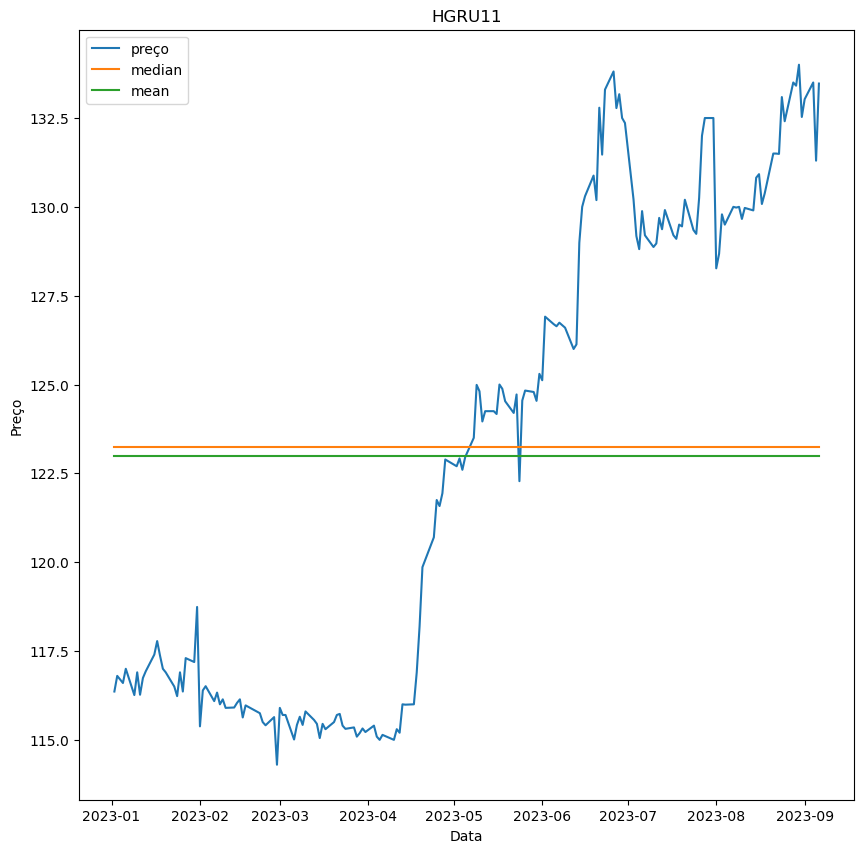

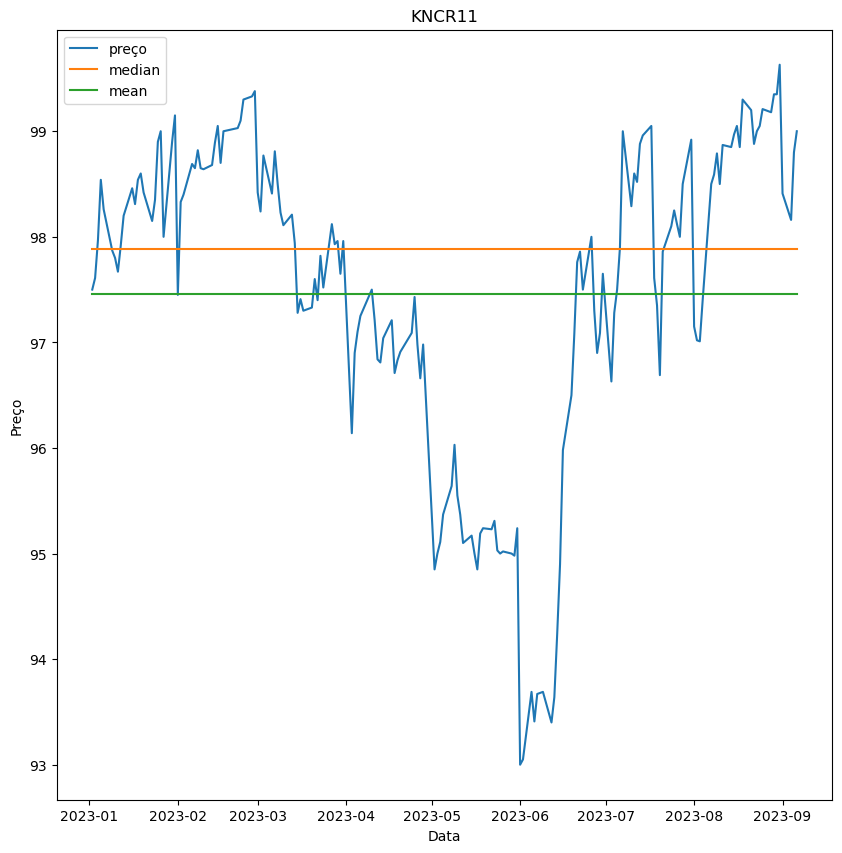

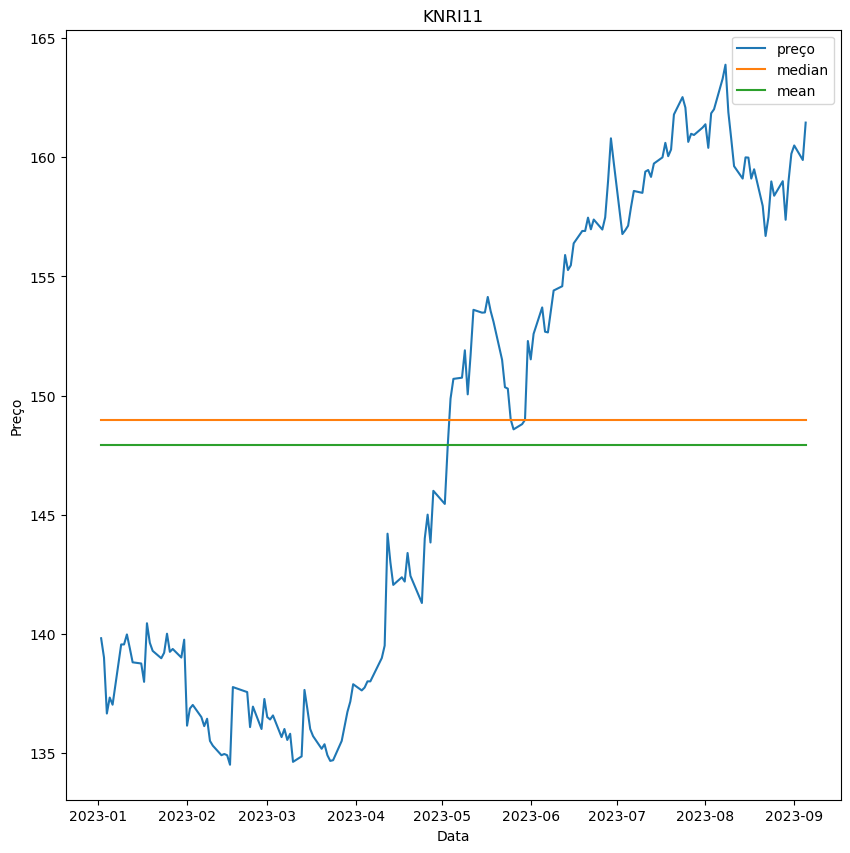

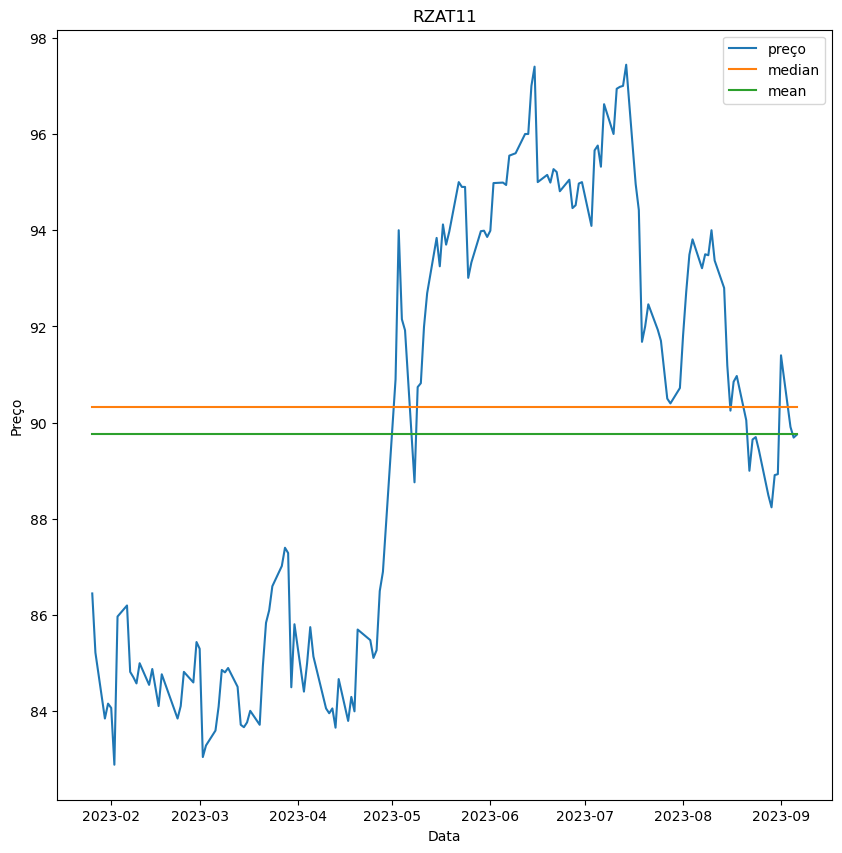

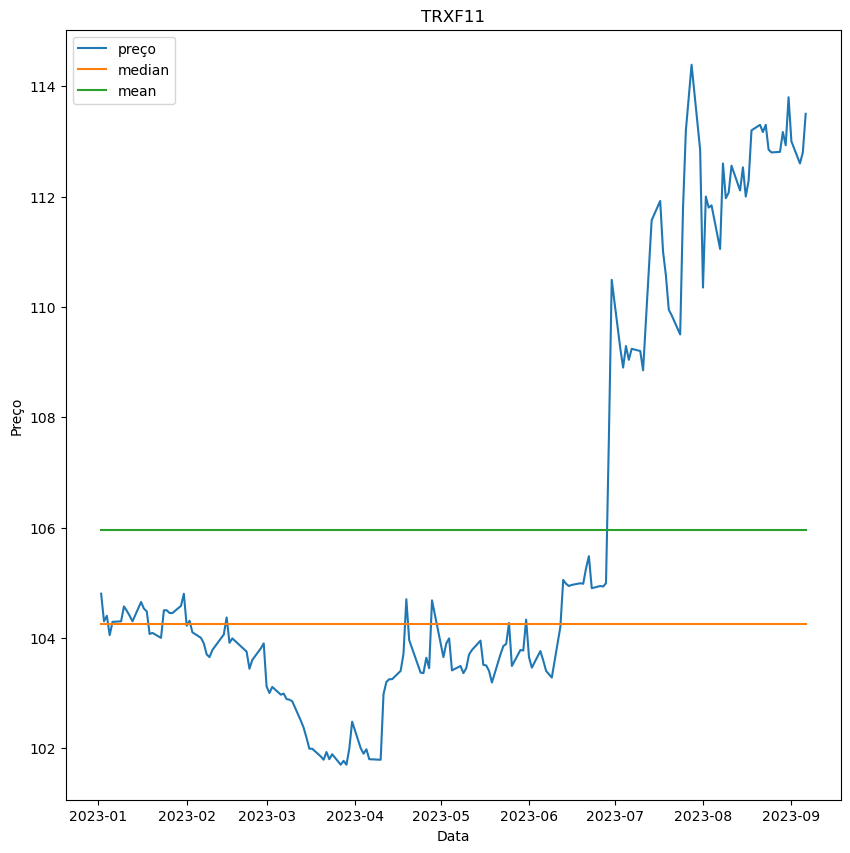

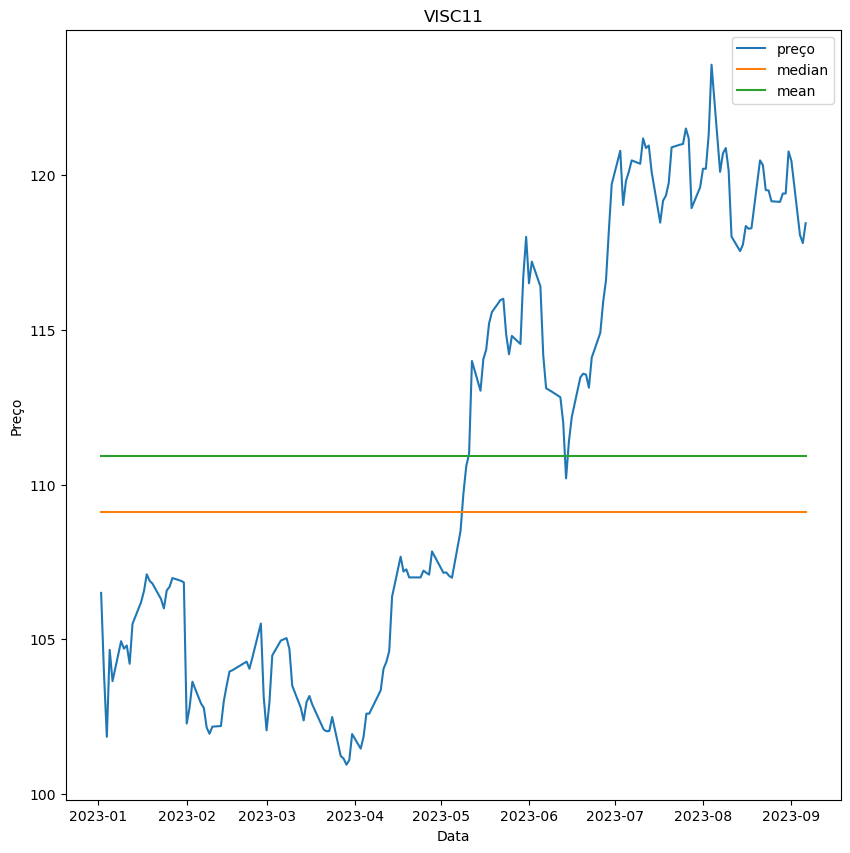

In [30]:
start='2023-01-01'
end='2023-09-30'


for stock in stocks_target:

    sub_df = df[df['CODIGO_DE_NEGOCIACAO'] == stock]

    if start != None:
        sub_df = sub_df[sub_df['DATA_DO_PREGAO'] >= pd.to_datetime(start)]

    if end != None:
        sub_df = sub_df[sub_df['DATA_DO_PREGAO'] <= pd.to_datetime(end)]

    sub_df['median'] = sub_df['PRECO_ULTIMO_NEGOCIO'].median()
    sub_df['mean'] = sub_df['PRECO_ULTIMO_NEGOCIO'].mean()

    x = sub_df['DATA_DO_PREGAO']
    y = sub_df['PRECO_ULTIMO_NEGOCIO']

    # plotting the points 
    plt.figure(figsize=(10,10))
    plt.plot(x,y, label="preço")
    # naming the x axis
    plt.xlabel('Data')
    # naming the y axis
    plt.ylabel('Preço')

    # median
    plt.plot(x,sub_df['median'],label='median')
    plt.plot(x,sub_df['mean'],label='mean')
    
    # giving a title to my graph
    plt.title(stock)
    plt.legend(loc='best')
    # function to show the plot
    plt.show()